### This tutorials analyzes the quality of deep deconv results using 2 criteria: pixel error and ellipticity error. It follows the tutorial_using_dnn

##### Set up the environment

In [16]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib
import numpy as np


In [17]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
matplotlib.rcParams['figure.figsize']=[12,8]



### 0) Set up all code needed

In [19]:
"""
Based on code written by alechat
"""

import os
from subprocess import Popen, PIPE

#This transforms a mosaic in extension idx_hdu and of size (gal_dim*sqrt(ngal),gal_dim*sqrt(ngal)) into a stamp_list 
def fits2npy(fits_file, idx_hdu,gal_dim=96,nb_gal=10000):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//gal_dim
    data_list = []
    idx_list = range(0, nb_gal)
    for i in idx_list:
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        data_list.append(data[x:x+gal_dim,y:y+gal_dim])
    return np.asarray(data_list)

#This translates a stamp_list [ngal,gal_dim,gal_dim,0] into a mosaic (gal_dim*sqrt(ngal),gal_dim*sqrt(ngal))
#Reverse operation of the previous function
def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

#This is the routine to compute the relative pixel error: ||X-Y||^2/(||Y||^2)
#hdu_target is the extension in the target_file containing the target
#We only compute the pixel error in a box centered on the galaxy (by default [28:69,28:69])
def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err


##### This is for ellipticity measurements

In [20]:
#This is the routine that call the C++ code to measure galaxy position, the shape of galaxies etc
def fast_generate_shape(gal_file, psf_file,output_file, cmd_file='get_shape.cmd', gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    #print('Computing ellipticity for file: %s'%(gal_file))
    #print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/cben-ali/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr


#Get the ellipticities measured from a file
def get_ellipticity(file_name):
    
    if".txt" in file_name:
        ellip = []
        with open(file_name, 'r') as f:
            data = f.readlines()
        for l in data:
            ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
        ellip=np.asarray(ellip)
    elif ".fits" in file_name:
        tab=fits.getdata(file_name)
        ellip=np.array([tab["E1"],tab["E2"]]).T
    return ellip

#Compute ellipticity errors based on two file names
def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err

#This is the ellipticity errors caused only be noise
def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

##### This is the code used for parallelization

In [21]:
import sharedmem as sm
AFFINITY_FLAG = False

def sharedmem_pool(used_cores):
    # see https://stackoverflow.com/questions/15639779
    global AFFINITY_FLAG
    if not AFFINITY_FLAG:
        AFFINITY_FLAG = True
        os.system("taskset -p 0xfff %d" % os.getpid())
    if used_cores is None:
        used_cores = sm.cpu_count()-2
    return sm.MapReduce(np=used_cores)

print(sm.cpu_count())

8


### 1) Let's visualize the input simulated images, psfs, targets

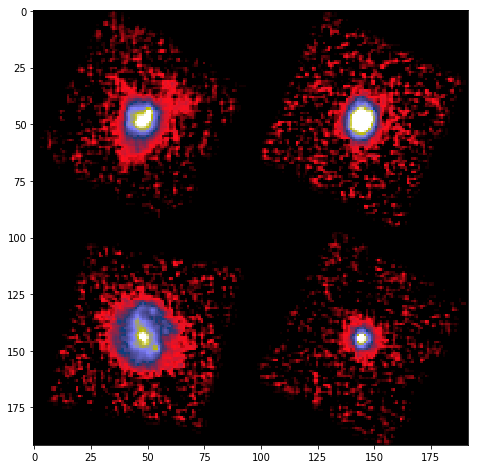

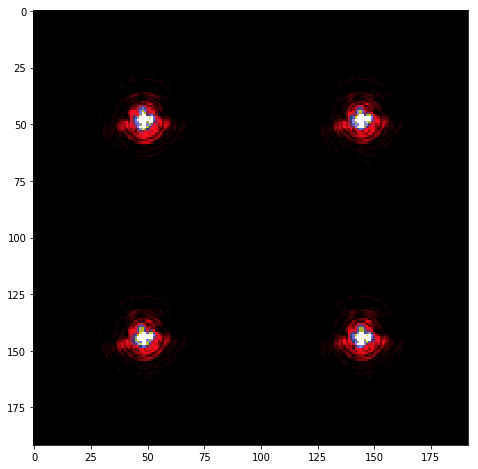

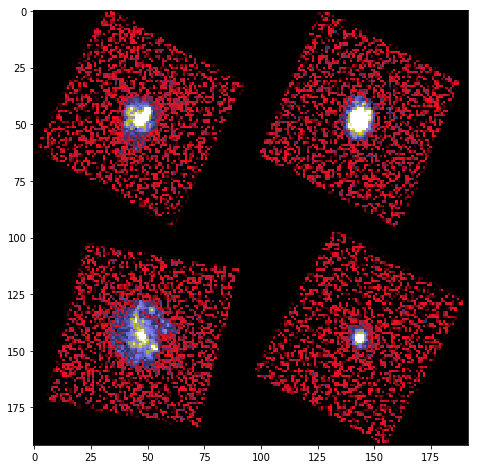

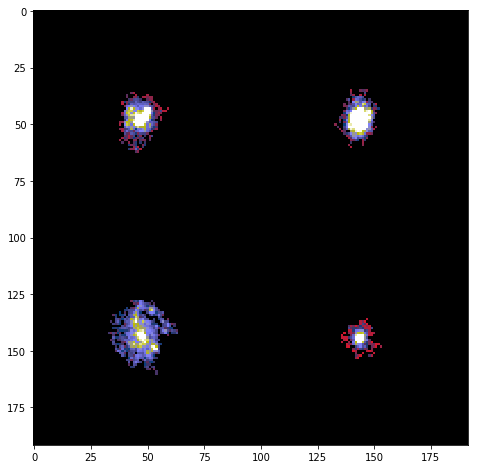

In [22]:
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
win_hdu=0

im0=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",noiseless_img_hdu)
psf=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",psf_hdu)
target=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",targets_hdu)
window=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Gaussian_window_claire_0.fits",win_hdu)

plt.imshow(im0[0:192,0:192],vmin=0,vmax=0.2,cmap='gist_stern')
plt.figure()
plt.imshow(psf[0:192,0:192],vmin=0,vmax=0.01,cmap='gist_stern')
plt.figure()
plt.imshow(target[0:192,0:192],vmin=0,vmax=0.2,cmap='gist_stern')
plt.figure()
plt.imshow(window[0:192,0:192],vmin=0,vmax=0.2,cmap='gist_stern')


### 2) Now we need to produce the DNN outputs for different SNRs

In [8]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as backk

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.47 

# Create a session with the above options specified.
backk.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

Using TensorFlow backend.


##### We set up the input dir, target name, network we want to process

In [9]:
write_path="/data/DeepDeconv/benchmark/claire/"
testset_file = 'image-shfl-0-multihdu.fits' #image of 10000 galaxies used for testing
# Input the hdf5 file, here we load a network trained on Tikhonov
net_path= '/home/cben-ali/Programs/deep-deconv/tutorials/'
net_file = 'DeconvNet_tuto_copy.hdf5' #network to analyse
net_root=net_file.replace('.hdf5','')
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')#Image collecting all targets
#The following is the data directory
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'

# Input the file containing the galaxies and psfs for testing
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
win_file='window/Gaussian_window_claire_0.fits'

noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2

#which list of networks we want to process
net_file_list=['ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5',
'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry.hdf5',
'ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart.hdf5'
]

#which SNR we want to investigate
SNR_list_sim=[20,40,60,80,100]#all of them:[20,40,60,80,100]



##### The following is for propagating the test image through the network

In [10]:
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch

tol=1e-12
for net_file in net_file_list:
    print("net_file={0}".format(net_file))
    for SNR_sim in SNR_list_sim:
        #Load input test for given SNR
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        if os.path.isfile(write_path+'images/'+mosaic_name):#Case it has already been processed
            print("Do not process {0}".format(mosaic_name))
        else:
            print("Process {0}".format(mosaic_name))
            if "risk" in net_file:#Case we have automated Tikhonov hyperparam choice
                deconv_mode="TIKHONOV_HYP"
                if "GCV" in net_file:
                    risktype="GCV"
                elif "SurePred" in net_file:
                    risktype="SurePred"
                elif "SureProj" in net_file:
                    risktype="SureProj"
                    if("tole-12" in net_file):
                        tol=1e-12
                    if("tole-3" in net_file):
                        tol=1e-3
                elif "Pereyra" in net_file:
                    risktype="Pereyra"
                else: #No hyperparameter choice
                    risktype=None
                    deconv_mode="TIKHONOV"
                if "regDirac" in net_file:
                    reg="Dirac"
                elif "regLap" in net_file:
                    reg="Lap"
                else:
                    reg=None
                if "regfrac" in net_file:
                    reg_frac=float(net_file.split("regfrac")[1].split("_")[0].replace('p','.'))
                    print("reg_frac={0}".format(reg_frac))
            else:#No hyperparameter choice
                risktype=None
                reg=None
                reg_frac=None
                deconv_mode="TIKHONOV"
            print("Deconv:",deconv_mode,risktype,reg,tol)
            #extract the whole image of galaxies at given SNR
            test_data, target_data, weights_data= get_batch_from_fits(testset_path+testset_file, 
                                                                      idx_list=np.arange(10000), SNR=SNR_sim,
                                                                      noiseless_img_hdu=noiseless_img_hdu,
                                                                      targets_hdu=targets_hdu,
                                                                      psf_hdu=psf_hdu, image_dim=96, 
                                                                      image_per_row=100, 
                                                                      deconv_mode=deconv_mode,
                                                                      risktype=risktype,reg=reg,
                                                                      tol=tol,reg_frac=reg_frac,
                                                                      shape_constraint=True,win_hdu=0,
                                                                      mom_hdu=1,
                                                                      win_filename=testset_path+win_file)
            if 'dnn' not in locals():#load dnn
                dnn = DeepNet(model_file=net_path+net_file,shape_constraint=True,gamma=0) #dnn is instance of DeepNet class
            #Use dnn for prediction
            dnn_reconstruction = dnn.predict(test_data, verbose=1)
            #collect all outputs as a mosaic and save them as a fits files.
            mosaic=StampCollection2Mosaic(dnn_reconstruction)
            hdu_dnn=fits.PrimaryHDU(mosaic)
            hdul = fits.HDUList([hdu_dnn])
            hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
    if 'dnn' in locals():#clear dnn
        del dnn


net_file=ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5
Do not process image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR20.fits
Do not process image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR40.fits
Do not process image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR60.fits
Do not process image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR80.fits
Do not process image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR100.fits
net_file=ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry.hdf5
Do not process image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry_testSNR20.fits
Do not process image-shfl-0-multihdu-ShapeNet2D

#### From here, we do not need deep learning  anymore

In [10]:
back.clear_session()

NameError: name 'backk' is not defined

#### Now look at results 

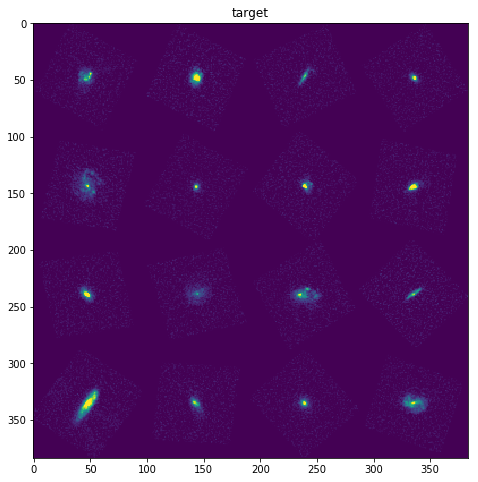

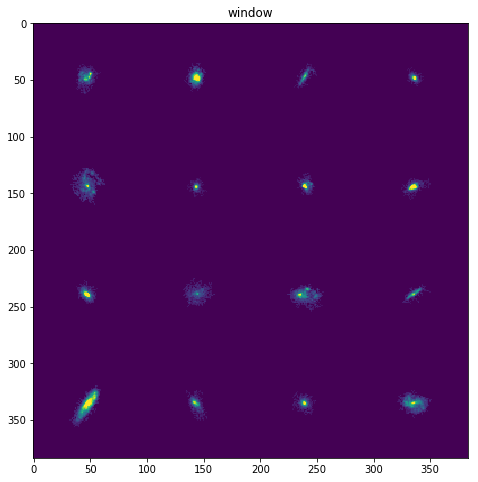

<Figure size 864x576 with 0 Axes>

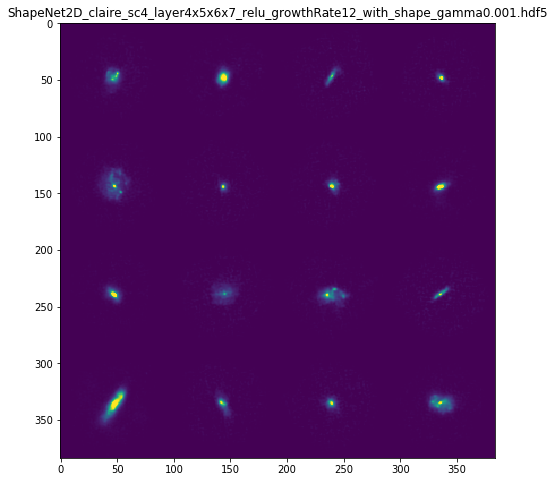

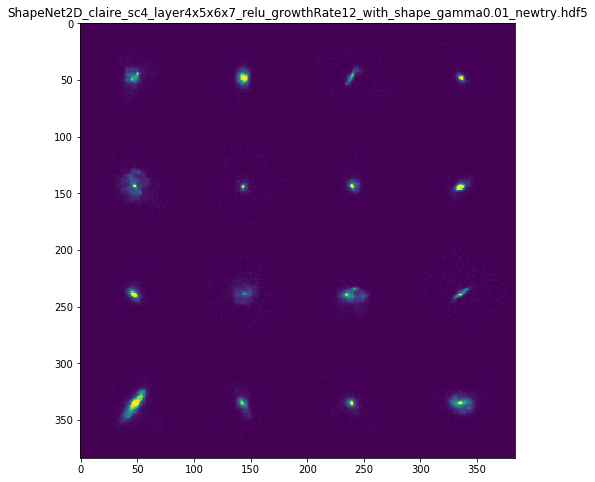

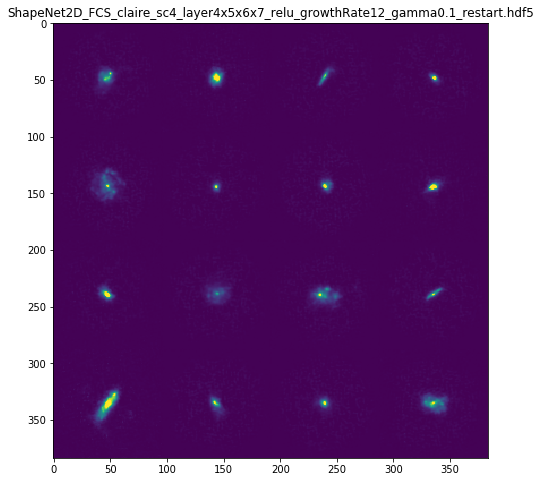

In [11]:
SNR_sim=100
target=fits.getdata("/data/DeepDeconv/benchmark/claire/images/image-shfl-0-multihdu-target_fwhm0p07.fits")
window=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Gaussian_window_claire_0.fits",win_hdu)


plt.imshow(target[0:384,0:384],vmin=0,vmax=0.5)
plt.title('target')
plt.figure()

plt.imshow(window[0:384,0:384],vmin=0,vmax=0.5)
plt.title('window')
plt.figure()

for net_file in net_file_list:
    plt.figure()
    mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
    restore_data=fits.getdata(write_path+'images/'+mosaic_name)
    plt.imshow(restore_data[0:384,0:384],vmin=0,vmax=0.5)
    plt.title(net_file)
    
    
    

### 3) Let's start with pixel error

##### We can start by checking how noise only impacts pixel error.

In [12]:
from DeepDeconv.utils.batch_utils import get_batch_from_fits
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  #we use one core per SNR if we have enough cores

SNR_list_sim=[20,40,60,80,100] #among [20,40,60,80,100] #List of SNR to be simulated

#We parallelize over SNR list
with sharedmem_pool(used_cores) as pool:
    def work(i):
        SNR_sim=SNR_list_sim[i]
        #This is the image+noise data
        mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
        if os.path.isfile(write_path+'images/'+mosaic_name):
            write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt')
            if not os.path.isfile(write_txt_name):
                with pool.critical:
                    print("Compute Pixel error {0}".format(mosaic_name) )
                #We compute the error between target and target+noise in a centered slice for each gal
                err=compute_pixel_error(write_path+'images/'+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                np.savetxt(write_txt_name,np.array(err))
            else:
                err=np.loadtxt(write_txt_name)
            with pool.critical:
                print(net_file," SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
        else:
            with pool.critical:
                print("not existing {0}".format(mosaic_name) )    

    pool.map(work, range(len(SNR_list_sim)))
        
    




ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart.hdf5  SNR= 40 MEAN_ERR= 1.205882999616784 MEDIAN_ERR= 1.205882999616784
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart.hdf5  SNR= 20 MEAN_ERR= 4.824730749591655 MEDIAN_ERR= 4.824730749591655
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart.hdf5  SNR= 80 MEAN_ERR= 0.301980570765778 MEDIAN_ERR= 0.301980570765778
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart.hdf5  SNR= 60 MEAN_ERR= 0.5355906941392824 MEDIAN_ERR= 0.5355906941392824
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart.hdf5  SNR= 100 MEAN_ERR= 0.19287156973596364 MEDIAN_ERR= 0.19287156973596364


##### Then we can compute the pixel error for the network outputs, parallelized over the different SNRs

In [13]:
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  #we use one core per SNR if we have enough cores
for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt')
                if not os.path.isfile(write_txt_name):
                    with pool.critical:
                        print("Compute Pixel error {0}".format(mosaic_name) )
                    err=compute_pixel_error(write_path+'images/'+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                    np.savetxt(write_txt_name,np.array(err))
                else:
                    #if it has already been measured, just print, do not recompute
                    err=np.loadtxt(write_txt_name)
                with pool.critical:
                    #Display results
                    print(net_file," SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
    



ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5  SNR= 40 MEAN_ERR= 0.11770231156963516 MEDIAN_ERR= 0.11770231156963516
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5  SNR= 20 MEAN_ERR= 0.1661995305431942 MEDIAN_ERR= 0.1661995305431942
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5  SNR= 60 MEAN_ERR= 0.10391962232282745 MEDIAN_ERR= 0.10391962232282745
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5  SNR= 100 MEAN_ERR= 0.08962294196761919 MEDIAN_ERR= 0.08962294196761919
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5  SNR= 80 MEAN_ERR= 0.09562774876336373 MEDIAN_ERR= 0.09562774876336373
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry.hdf5
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry

### 4) Compute ellipticity errors

##### To compute ellipticity errors, we need to 1) first define a gaussian window per galaxy based on target 2) measure the ellipticity of target galaxies taking into account the targeted psf 3) measure the ellipticity of images outputted by the network using the same gaussian window and taking into account the target psf 4) compute the euclidean distance in between the two ellipticity measures

#### a) This only needs to be done once (compute gaussian window for each target galaxy, and ellipticity measurement associated)

In [15]:
#We use the same window function as the one computed on target images
save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')

#perform target ellipticity measurements (just need to do once)
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.fits')
#The option -o means we output the windows per galaxy and save them to the filepath save_weights
#Uncomment to generate the reference:
#_,_=fast_generate_shape(write_path+'images/'+target_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')

#### b) Now compute the ellipticity as well for the outputs of the network

In [21]:
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.fits'.format(SNR_sim))
                save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')
                if not os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip {0}".format(mosaic_name) )
                    cmd_file = '../scripts/fast_get_shape/get_shape_{0}.cmd'.format(mosaic_name.replace('.fits','_ellipmes_targetweights'))
                    #The option -i means we input the windows per galaxy in save_weights
                    _,_=fast_generate_shape(write_path+'images/'+mosaic_name, psf_file, ellip_filename,cmd_file=cmd_file, mosaic_size=100, save_weights=save_weights, weights_input='-i')
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )
        pool.map(work, range(len(SNR_list_sim)))
    




ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5
Compte Ellip image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR20.fits
/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output -i /data/DeepDeconv/benchmark/claire/ellip/image-shfl-0-multihdu-target_fwhm0p07_weights.fits -p /data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits -g 100 -s 96 -T /data/DeepDeconv/benchmark/claire/images/image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR20.fits /data/DeepDeconv/benchmark/claire/ellip/image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR20_ellipmes_targetweights.fits
Compte Ellip image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR60.fits
Compte Ellip image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamm

Compte Ellip image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR60.fits
/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output -i /data/DeepDeconv/benchmark/claire/ellip/image-shfl-0-multihdu-target_fwhm0p07_weights.fits -p /data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits -g 100 -s 96 -T /data/DeepDeconv/benchmark/claire/images/image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR60.fits /data/DeepDeconv/benchmark/claire/ellip/image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR60_ellipmes_targetweights.fits
Compte Ellip image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR80.fits
/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output -i /data/DeepDeconv/benchmark/claire/ellip/image-shfl-0-multihdu-target_fwhm0p07_weights.fits -p /data/DeepDeconv/data/gauss_

#### c)  Now compute the ellipticity error based on the two measures of ellipticity

ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001.hdf5
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR20.fits


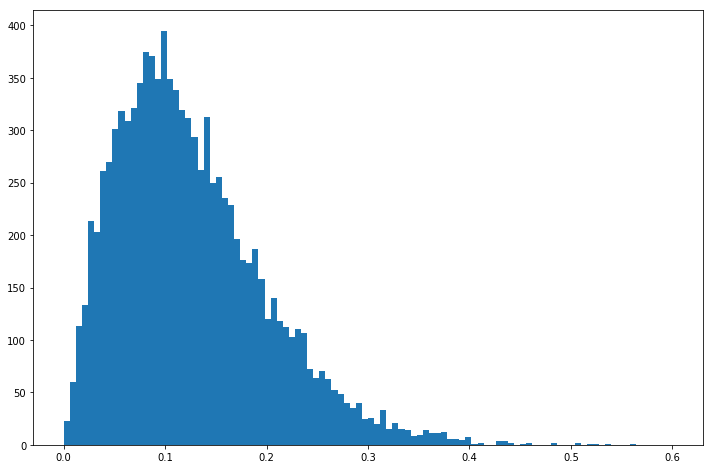

Total samples = 9987
SNR= 20 MEAN_ERR= 0.12617639 MEDIAN_ERR= 0.11293465
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR40.fits


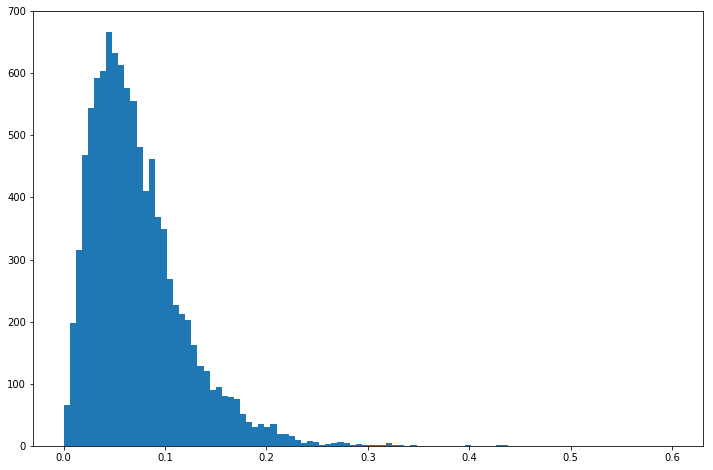

Total samples = 9988
SNR= 40 MEAN_ERR= 0.07234865 MEDIAN_ERR= 0.063077025
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR60.fits


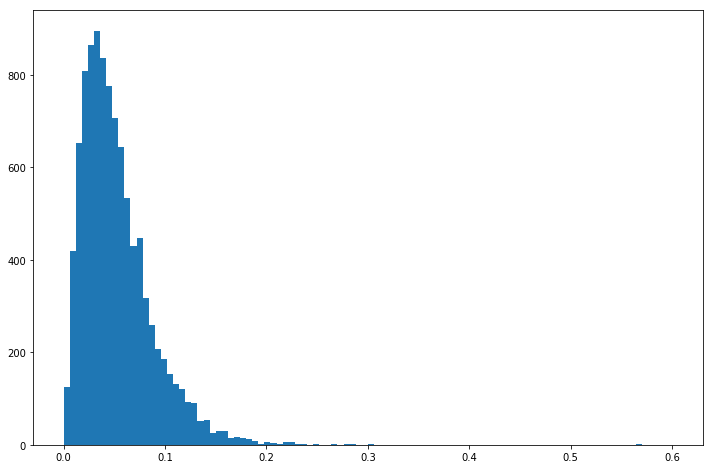

Total samples = 9985
SNR= 60 MEAN_ERR= 0.05222491 MEDIAN_ERR= 0.04502573
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR80.fits


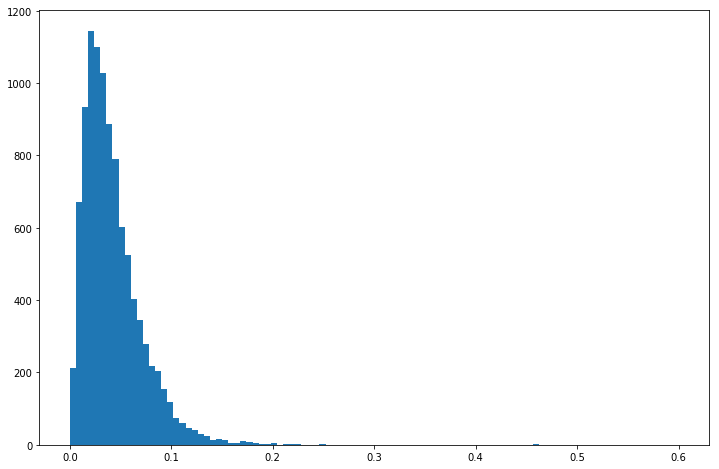

Total samples = 9986
SNR= 80 MEAN_ERR= 0.041941274 MEDIAN_ERR= 0.03541648
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_testSNR100.fits


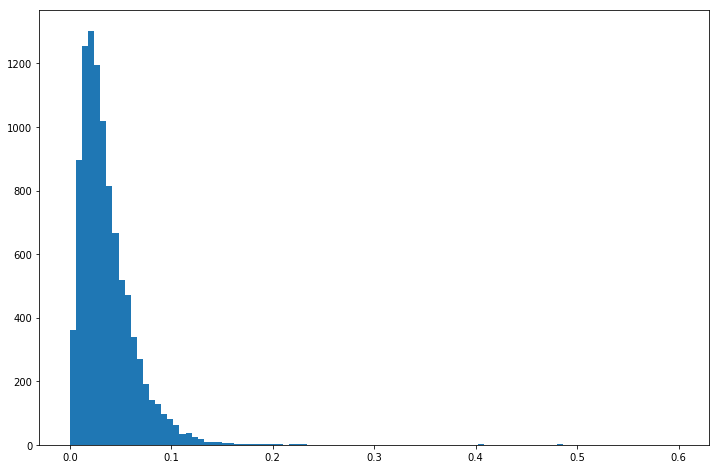

Total samples = 9985
SNR= 100 MEAN_ERR= 0.03612851 MEDIAN_ERR= 0.029864674
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry.hdf5
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry_testSNR20.fits


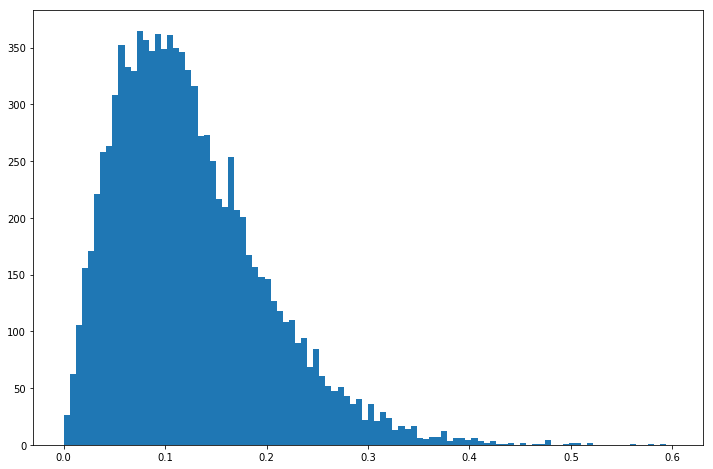

Total samples = 9986
SNR= 20 MEAN_ERR= 0.1253215 MEDIAN_ERR= 0.11235632
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry_testSNR40.fits


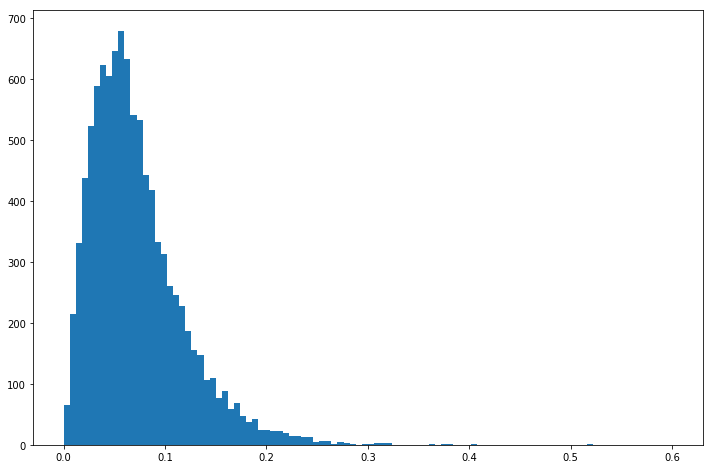

Total samples = 9988
SNR= 40 MEAN_ERR= 0.07193235 MEDIAN_ERR= 0.06245082
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry_testSNR60.fits


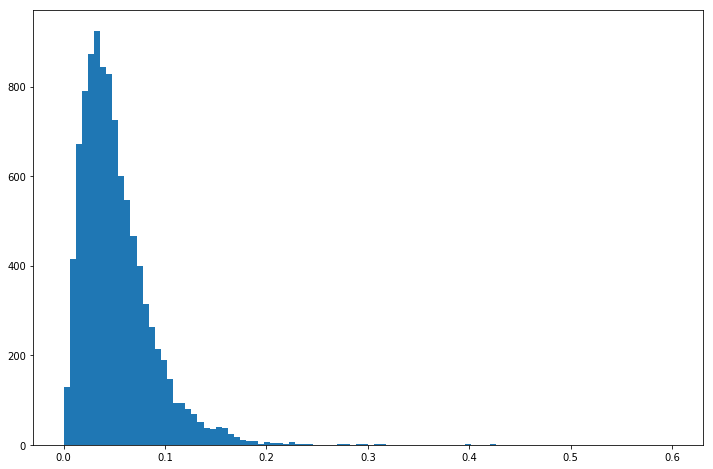

Total samples = 9984
SNR= 60 MEAN_ERR= 0.05158428 MEDIAN_ERR= 0.04441864
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry_testSNR80.fits


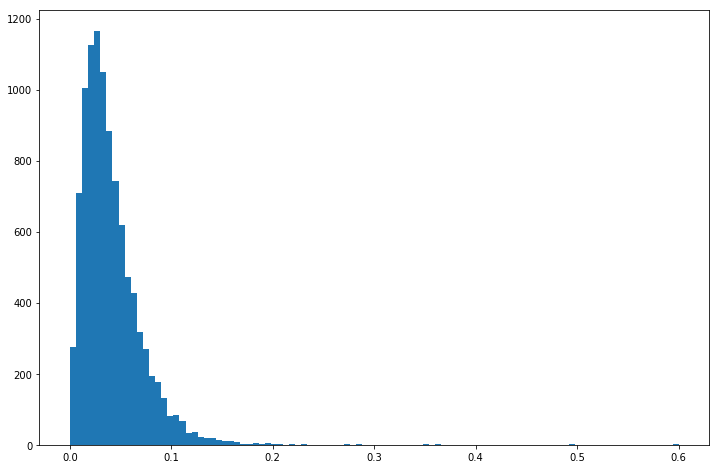

Total samples = 9987
SNR= 80 MEAN_ERR= 0.040433392 MEDIAN_ERR= 0.033997465
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_newtry_testSNR100.fits


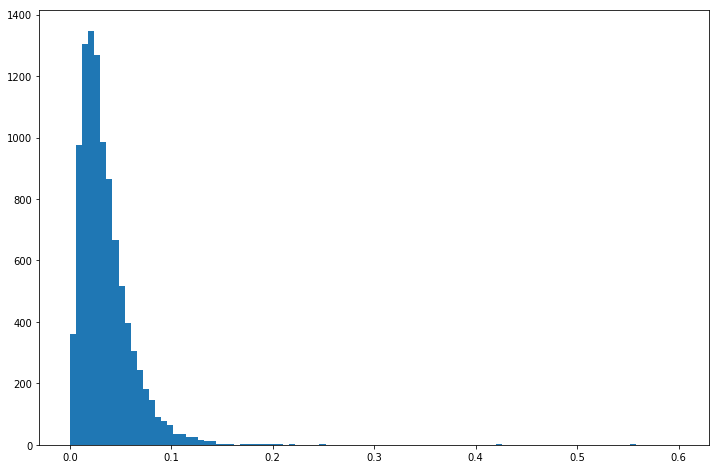

Total samples = 9985
SNR= 100 MEAN_ERR= 0.03460428 MEDIAN_ERR= 0.028686995
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart.hdf5
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR20.fits


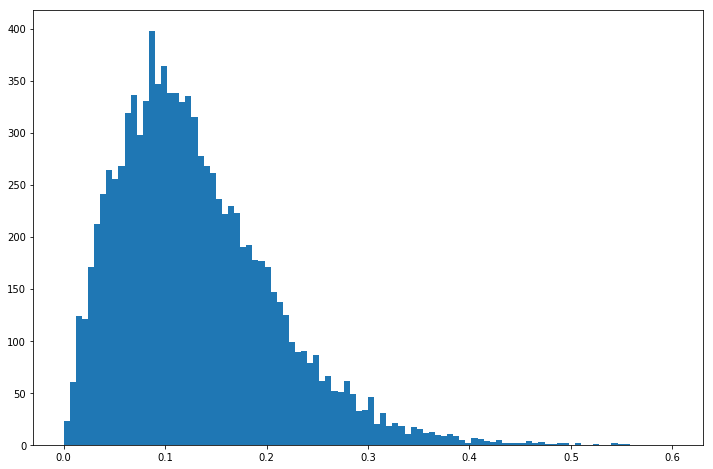

Total samples = 9987
SNR= 20 MEAN_ERR= 0.1305192 MEDIAN_ERR= 0.11746211
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR40.fits


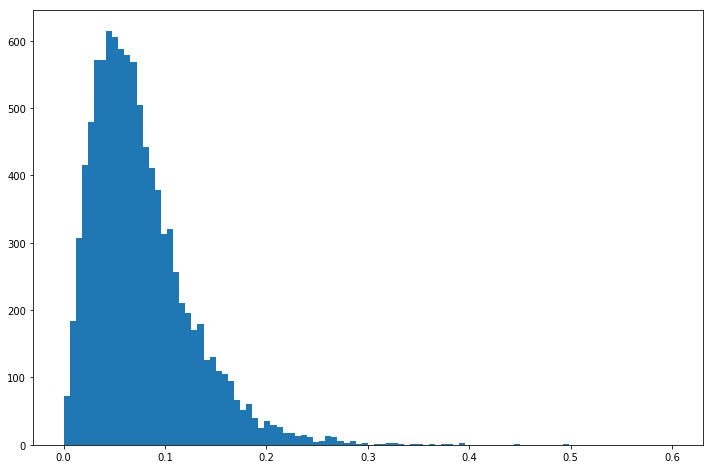

Total samples = 9988
SNR= 40 MEAN_ERR= 0.07576716 MEDIAN_ERR= 0.06604053
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR60.fits


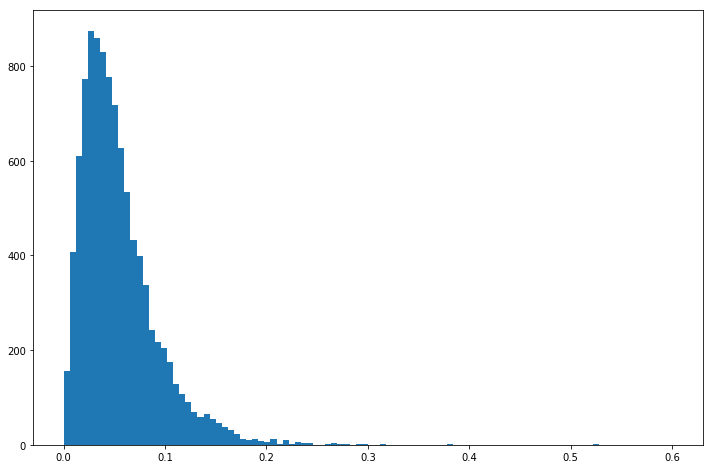

Total samples = 9986
SNR= 60 MEAN_ERR= 0.053852443 MEDIAN_ERR= 0.045578837
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR80.fits


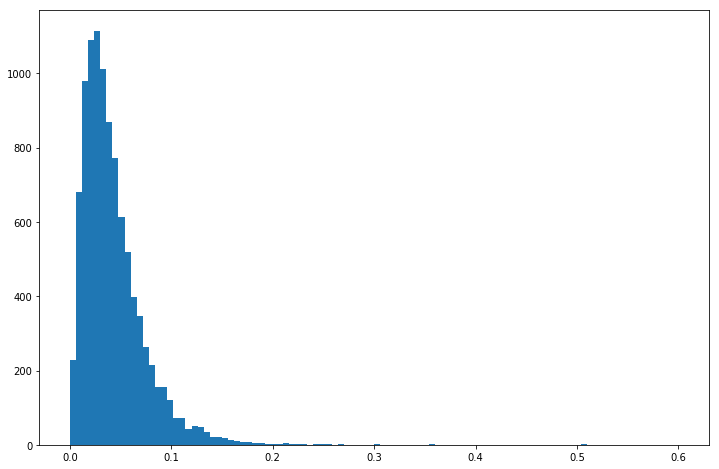

Total samples = 9985
SNR= 80 MEAN_ERR= 0.042475108 MEDIAN_ERR= 0.03526097
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.1_restart_testSNR100.fits


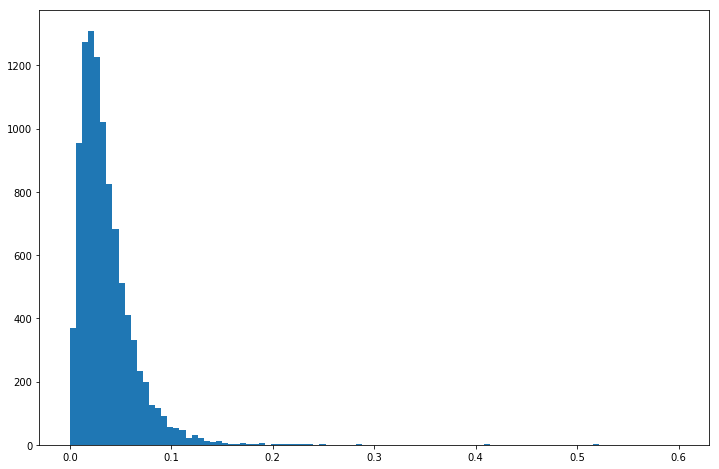

Total samples = 9985
SNR= 100 MEAN_ERR= 0.035460785 MEDIAN_ERR= 0.029214535


In [22]:
ellip_filename_ref=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.fits')

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(1) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.fits'.format(SNR_sim))
                if os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip error {0}".format(mosaic_name) )
                        ell_err=compute_ellipticity_error(ellip_filename_ref, ellip_filename, plot_hist=True, max_idx=10000)
                        print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(ell_err),"MEDIAN_ERR=",np.median(ell_err))
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
    


